In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.dfloader  import DataFrameLoader 
from mltools.modelwrappers.xgbwrapper import XgBoostWrapper
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [3]:
pkmn_type_colors = [
                    
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                    '#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    ]

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred


def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [5]:
load_app_config()
input_path = get_datafolder_path()
DIRECTORY ="noshowappointments"
TRAIN_FILE  = "KaggleV2-May-2016.csv"
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)

In [6]:
from datetime import datetime
datatypes = {'PatientId': np.float64, 'AppointmentID': np.int64, 'Gender': str, 'ScheduledDay': str,
             'AppointmentDay': str, 'Age': np.int32, 'Neighbourhood': str, 'Scholarship': np.int32, 'Hipertension': np.int32,
             'Diabetes': np.int32, 'Alcoholism': np.int32, 'Handcap': np.int32, 'SMS_received': np.int32,
             'No-show': str}
 

In [7]:
train_df = DataFrameLoader(train_file, dtype=datatypes,).dataframe

In [8]:
#train_df['No-show'].replace('No', 0,inplace=True)
#train_df['No-show'].replace('Yes', 1,inplace=True)
#train_df['Gender'].replace('F', 0,inplace=True)
#train_df['Gender'].replace('M', 1,inplace=True)
train_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.1053e+05,1.1053e+05,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000
mean,1.4750e+14,5.6753e+06,37.0889,0.0983,0.1972,0.0719,0.0304,0.0222,0.3210
std,2.5609e+14,7.1296e+04,23.1102,0.2977,0.3979,0.2583,0.1717,0.1615,0.4669
min,3.9218e+04,5.0302e+06,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4.1726e+12,5.6403e+06,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,3.1732e+13,5.6806e+06,37.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,9.4392e+13,5.7255e+06,55.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
max,9.9998e+14,5.7905e+06,115.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000


In [9]:
def reassign_datatypes(data, columns, column_types):
    assert len(columns) == len(column_types)
    assert set(columns).issubset(data.columns.values)
    for column, column_type in zip(columns, column_types):
        data[column] = data[column].astype(column_type)
    return data

In [10]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        if n.startswith('Is'):
            df[targ_pre + n] =df[targ_pre + n].astype(int)
            
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop:
        df.drop(fldname, axis=1, inplace=True)

In [11]:
train_df = reassign_datatypes(train_df, ['PatientId'], [np.int64])
train_df['ScheduledDay'] = pd.to_datetime(train_df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
train_df['AppointmentDay'] = pd.to_datetime(train_df['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')

In [12]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


##### Check any rows with all values missing
##### Check how many features have constant value , if any remove unique values  have no contribution in predictive models

In [13]:
from mltools.mlhelper import missing_values
training_missing_values = missing_values(train_df)
all_missing  = training_missing_values[training_missing_values['Missing_Values'] ==train_df.shape[0]]
print("No of columns that have 100% missing values :{0}".format(all_missing.shape[0]))
all_missing.head()


No of columns that have 100% missing values :0


,Feature,Missing_Values,Percent_of_Total_Values


In [14]:
add_datepart(train_df,'ScheduledDay',drop=False,time=True)

In [15]:
add_datepart(train_df,'AppointmentDay',drop=False,time=False)

In [16]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayYear,ScheduledDayMonth,ScheduledDayWeek,ScheduledDayDay,ScheduledDayDayofweek,ScheduledDayDayofyear,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,ScheduledDayIs_year_end,ScheduledDayIs_year_start,ScheduledDayHour,ScheduledDayMinute,ScheduledDaySecond,ScheduledDayElapsed,AppointmentDayYear,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayDayofyear,AppointmentDayIs_month_end,AppointmentDayIs_month_start,AppointmentDayIs_quarter_end,AppointmentDayIs_quarter_start,AppointmentDayIs_year_end,AppointmentDayIs_year_start,AppointmentDayElapsed
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016,4,17,29,4,120,0,0,0,0,0,0,18,38,8,1461955088,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016,4,17,29,4,120,0,0,0,0,0,0,16,8,27,1461946107,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016,4,17,29,4,120,0,0,0,0,0,0,16,19,4,1461946744,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016,4,17,29,4,120,0,0,0,0,0,0,17,29,31,1461950971,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016,4,17,29,4,120,0,0,0,0,0,0,16,7,23,1461946043,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000


In [17]:
train_df['Handcap'] = train_df['Handcap'].astype(str)

In [18]:
train_df.drop(train_df[train_df['ScheduledDayYear']==2015].index,inplace=True)

In [19]:
patient_id_count = train_df.groupby(['PatientId', 'No-show'], as_index=False)['PatientId'].agg(['count'])
patient_id_count.rename(columns={'PatientId': 'count'}, inplace=True)

In [20]:
train_df.drop(train_df[train_df['Age'] ==-1].index,inplace=True)

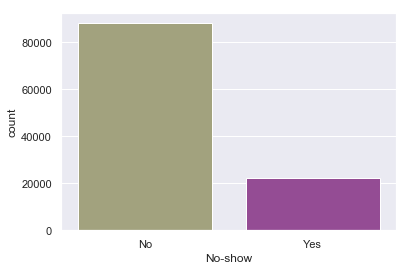

In [21]:
ax = sns.countplot(x="No-show", data=train_df,palette=pkmn_type_colors)

#####  As shown its a highly imbalanced dataset

In [22]:
feature_count  = train_df.nunique(dropna=False)
constant_features = pd.DataFrame({'feature':feature_count.index,'count':feature_count.values})
print("constant features :{0},{1}".format(*constant_features.shape))
constant_features[constant_features['count']==1] 

constant features :43,2


,feature,count
14,ScheduledDayYear,1
24,ScheduledDayIs_year_end,1
25,ScheduledDayIs_year_start,1
30,AppointmentDayYear,1
38,AppointmentDayIs_quarter_end,1
39,AppointmentDayIs_quarter_start,1
40,AppointmentDayIs_year_end,1
41,AppointmentDayIs_year_start,1


In [23]:
train_df.drop(constant_features[constant_features['count']==1]['feature'].values,axis =1,inplace=True)

In [24]:
continuous = ['Age']
columns_to_ignore =['PatientId','AppointmentID','Neighbourhood','No-show']
categorical = [column  for column in train_df.columns.values if column not in continuous+columns_to_ignore]


In [25]:
# f = pd.melt(train_df, value_vars=sorted(categorical[:12]))
# g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
# plt.xticks(rotation='vertical')
# g = g.map(sns.countplot, 'value')
# [plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
# g.fig.tight_layout()
# plt.show()

In [26]:
# f = pd.melt(train_df, value_vars=sorted(categorical[13:]))
# g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
# plt.xticks(rotation='vertical')
# g = g.map(sns.countplot, 'value')
# [plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
# g.fig.tight_layout()
# plt.show()

In [27]:
# for column in ['ScheduledDayMonth','ScheduledDayWeek',]:
#     g=sns.factorplot("No-show", col = column, 
#                    data = train_df[train_df[column].notnull()],kind = "count",
#                    palette=pkmn_type_colors,size=5,aspect=1,col_wrap=4)
#     g.fig.get_axes()[0].set_yscale('log')
#     plt.show()

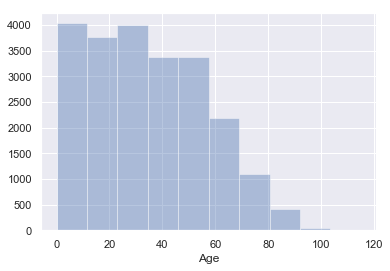

In [44]:
sns.distplot(train_df[train_df['No-show']=='Yes']['Age'],bins=10, kde=False)

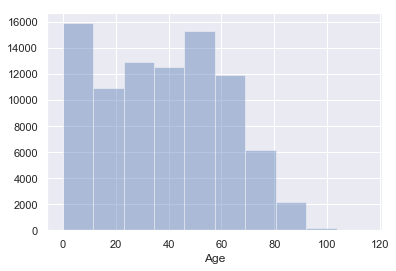

In [45]:
sns.distplot(train_df[train_df['No-show']=='No']['Age'],bins=10, kde=False)

In [30]:
#train_df['Age'] =np.log1p(train_df['Age'])

In [46]:
#categorical.append('binned_Age')
cat_data =  train_df[categorical+['No-show']]

In [32]:
#bins =  list(np.linspace(0,100,11))
#display(bins)
#display(list(range(len(bins))))

#bins = list(np.linspace(0,100,11))
#labels = list(range(len(bins)-1))
#train_df['binned_Age'] = pd.cut(train_df['Age'], bins=bins, labels=labels)

In [33]:
#train_df['binned_Age'].fillna(0,inplace=True)
#train_df['binned_Age'] =train_df['binned_Age'].astype(str)

In [34]:
# from scipy import stats
# def anova(frame,categorical_features):
#     anv = pd.DataFrame()
#     anv['features'] = categorical_features
#     pvals = []
#     for c in categorical_features:
#         samples = []
#         for cls in frame[c].unique():
#             s = frame[frame[c] == cls]['No-show'].values
#             samples.append(s)
#         pval = stats.f_oneway(*samples)[1]
#         pvals.append(pval)
#     anv['pval'] = pvals
#     return anv.sort_values('pval')

 
# k = anova(cat_data,categorical) 
# k['disparity'] = np.log(1./k['pval'].values) 

# plt.figure(figsize=(10,8))
# sns.barplot(data=k, x = 'features', y='disparity') 
# plt.xticks(rotation=90) 
# plt 

In [35]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayMonth,ScheduledDayWeek,ScheduledDayDay,ScheduledDayDayofweek,ScheduledDayDayofyear,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,ScheduledDayHour,ScheduledDayMinute,ScheduledDaySecond,ScheduledDayElapsed,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayDayofyear,AppointmentDayIs_month_end,AppointmentDayIs_month_start,AppointmentDayElapsed
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,17,29,4,120,0,0,0,0,18,38,8,1461955088,4,17,29,4,120,0,0,1461888000
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,17,29,4,120,0,0,0,0,16,8,27,1461946107,4,17,29,4,120,0,0,1461888000
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,17,29,4,120,0,0,0,0,16,19,4,1461946744,4,17,29,4,120,0,0,1461888000
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,17,29,4,120,0,0,0,0,17,29,31,1461950971,4,17,29,4,120,0,0,1461888000
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,17,29,4,120,0,0,0,0,16,7,23,1461946043,4,17,29,4,120,0,0,1461888000


AppointmentDayMonth  No-show
4                    No          2602
                     Yes          633
5                    No         64011
                     Yes        16793
6                    No         21551
                     Yes         4874
Name: No-show, dtype: int64

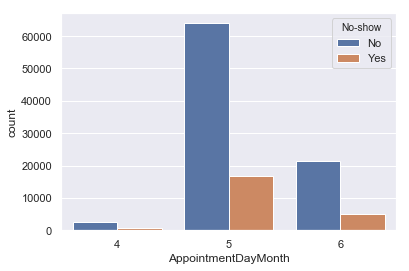

In [41]:
no_shows_by_month = train_df.groupby(['AppointmentDayMonth','No-show'])['No-show'].agg('count')
display(no_shows_by_month)
ax = sns.countplot(x="AppointmentDayMonth", hue="No-show", data=train_df)

AppointmentDayWeek  No-show
17                  No          2602
                    Yes          633
18                  No         16679
                    Yes         4265
19                  No         17071
                    Yes         4641
20                  No         16782
                    Yes         4663
21                  No          6341
                    Yes         1569
22                  No         17571
                    Yes         4068
23                  No         11118
                    Yes         2461
Name: No-show, dtype: int64

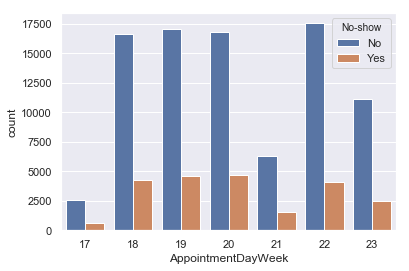

In [42]:
no_shows_by_day = train_df.groupby(['AppointmentDayWeek','No-show'])['No-show'].agg('count')
display(no_shows_by_day)
ax = sns.countplot(x="AppointmentDayWeek", hue="No-show", data=train_df)

AppointmentDayDayofweek  No-show
0                        No         18024
                         Yes         4689
1                        No         20488
                         Yes         5152
2                        No         20739
                         Yes         5077
3                        No         13909
                         Yes         3338
4                        No         14974
                         Yes         4035
5                        No            30
                         Yes            9
Name: No-show, dtype: int64

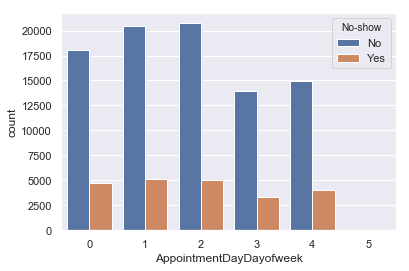

In [43]:
no_shows_by_Dayofweek = train_df.groupby(['AppointmentDayDayofweek','No-show'])['No-show'].agg('count')
display(no_shows_by_Dayofweek)
ax = sns.countplot(x="AppointmentDayDayofweek", hue="No-show", data=train_df)

In [48]:
" ,".join(categorical)

'Gender ,ScheduledDay ,AppointmentDay ,Scholarship ,Hipertension ,Diabetes ,Alcoholism ,Handcap ,SMS_received ,ScheduledDayMonth ,ScheduledDayWeek ,ScheduledDayDay ,ScheduledDayDayofweek ,ScheduledDayDayofyear ,ScheduledDayIs_month_end ,ScheduledDayIs_month_start ,ScheduledDayIs_quarter_end ,ScheduledDayIs_quarter_start ,ScheduledDayHour ,ScheduledDayMinute ,ScheduledDaySecond ,ScheduledDayElapsed ,AppointmentDayMonth ,AppointmentDayWeek ,AppointmentDayDay ,AppointmentDayDayofweek ,AppointmentDayDayofyear ,AppointmentDayIs_month_end ,AppointmentDayIs_month_start ,AppointmentDayElapsed'

AppointmentDayDay  No-show
1                  No         3648
                   Yes         808
2                  No         7023
                   Yes        1662
3                  No         6702
                   Yes        1634
4                  No         3189
                   Yes         972
5                  No         3466
                   Yes         807
6                  No         6902
                   Yes        1668
7                  No         3600
                   Yes         816
8                  No         3700
                   Yes         772
9                  No         3501
                   Yes        1019
10                 No         3316
                   Yes         992
11                 No         3585
                   Yes         879
12                 No         3557
                   Yes         837
13                 No         3082
                   Yes         905
14                 No           30
                   Yes      

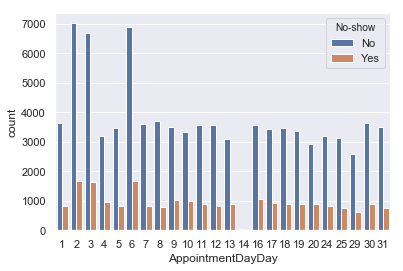

In [51]:
no_shows_by_DayDay= train_df.groupby(['AppointmentDayDay','No-show'])['No-show'].agg('count')
display(no_shows_by_DayDay)
ax = sns.countplot(x="AppointmentDayDay", hue="No-show", data=train_df)

In [36]:
Check

NameError: name 'Check' is not defined

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

In [ ]:
mosaic(train_df, ['No-show','Gender','Hipertension'])
plt.show()

In [ ]:
train_df.drop(['PatientId','AppointmentID','Neighbourhood',],axis=1,inplace=True,)

In [ ]:
train_df.drop(['ScheduledDay','AppointmentDay',],axis =1,inplace=True)

In [ ]:
train_df.drop(['ScheduledDayDay','ScheduledDayHour',
               'ScheduledDayMonth','ScheduledDayWeek','ScheduledDayDayofweek',
               'ScheduledDayDayofyear' 
              ],axis =1,inplace=True)
train_df.drop(['ScheduledDayElapsed','AppointmentDayElapsed',
              'ScheduledDaySecond','ScheduledDayMinute','AppointmentDayDayofyear'
             ],axis=1,inplace=True)

In [ ]:
y_train_df =train_df['No-show']
train_df.drop(['No-show'],axis =1,inplace=True)

In [ ]:
correlation = train_df[train_df.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
full_dataset = pd.get_dummies(train_df, prefix_sep='_', drop_first=False)

In [ ]:
full_dataset.drop(['Handcap_1'],axis=1,inplace=True)

In [ ]:
y_train_df.head()

In [ ]:
full_dataset.head()

In [ ]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.30
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(full_dataset, y_train_df, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=2)

In [ ]:
display(full_dataset.shape)
display(X_trainmodel.shape)
display(X_val.shape)

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# clf = ExtraTreesClassifier(random_state=42)
# selector = clf.fit(X_trainmodel, y_trainmodel)

# # plot most important features
# feat_imp = pd.Series(clf.feature_importances_, index = X_trainmodel.columns.values).sort_values(ascending=False)
# feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
# plt.ylabel('Feature Importance Score')
# plt.subplots_adjust(bottom=0.3)
# plt.savefig('1.png')
# plt.show()

# # clf.feature_importances_ 
# fs = SelectFromModel(selector, prefit=True)

# X_trainmodel = fs.transform(X_trainmodel)
# X_val = fs.transform(X_val)

In [ ]:
from xgboost.sklearn import XGBClassifier

xgbr = XGBClassifier(n_estimators=50, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())
plot_roc(X_val,y_val,xgbr)

In [ ]:
def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()  
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [ ]:
def calc_accuracy2(predictions, y_test):
    return 'accuracy_score', (1 - sum(y_test != predictions)/len(y_test))

In [ ]:
import xgboost as xgb

In [ ]:
xgb_params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 1,
          'colsample_bylevel': 0.8,
          'gamma': 0,
          'min_child_weight': 1.0,
          'alpha': 1,
          "silent": 1,
          'nrounds':20
          }

params_X = {
    "objective": "multi:softmax",
     'num_class': 2,
    'eta': 0.04,
    'max_depth': 5,
    'min_child_weight': 9.15,
    'gamma': 0.59,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 10.4,
    'lambda': 5,
    'nthread': 4,
    'silent': 1,
}
num_boost_round =15

In [ ]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)
# 
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params_X, dtrain, num_boost_round, watchlist,feval=calc_accuracy,
                maximize=True, early_stopping_rounds=50, verbose_eval=True)

In [ ]:
#xg = XgBoostWrapper(seed=27, params=xgb_params)
#xg.train(X_trainmodel, y_trainmodel)
#y_val_pred = xg.predict(X_val)
#calc_accuracy2(y_val_pred,y_val)

In [ ]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [ ]:
heatmap_data =X_trainmodel
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.90
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['SalePrice','LogSalePrice']]
to_drop    

In [ ]:
correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)